In [38]:
import numpy as np
import matplotlib.pyplot as plt 
from allison.utils.metrics import r2_score

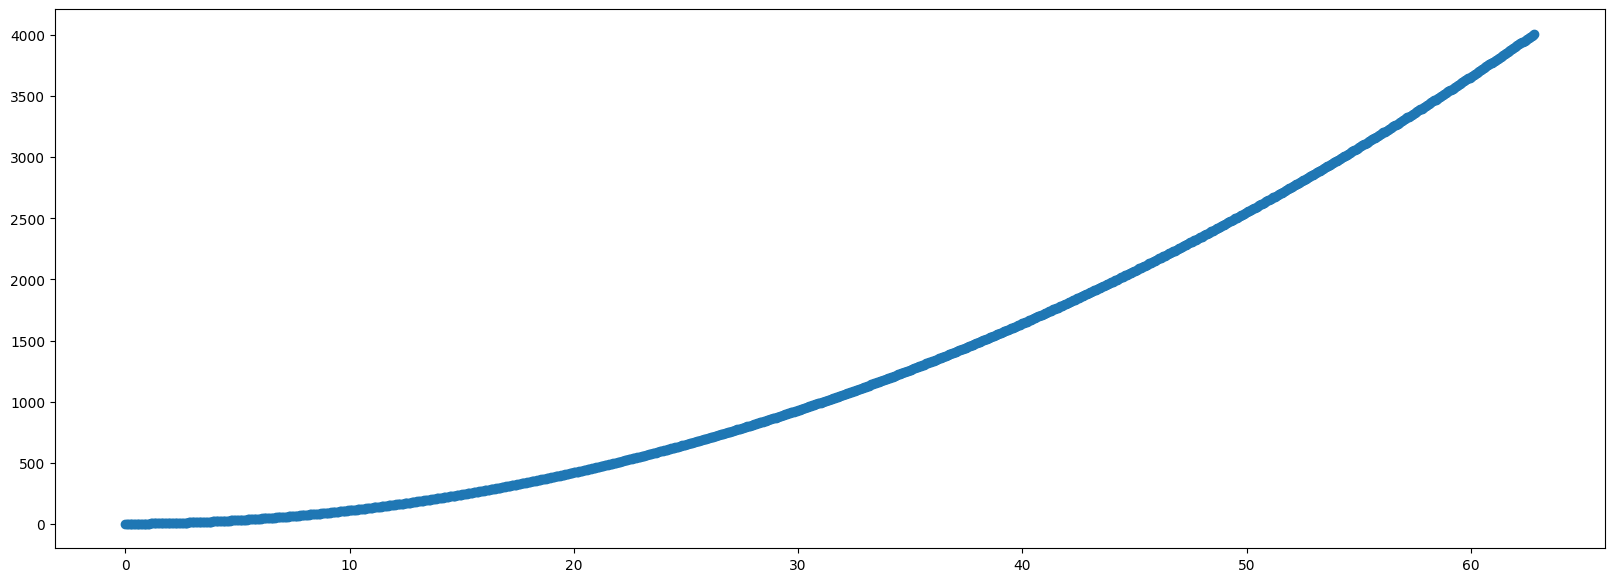

In [39]:
points = 1000

x1 = np.linspace(0,20*np.pi,points)
x2 = np.linspace(0,20*np.pi,points)

y =  x1**2 + x2

plt.figure(figsize=(20, 7))
plt.scatter(x2, y)

In [40]:
import numpy as np

class Tensor:
    def __init__(self, data, _children=(), _op=''):
        self.data = data if isinstance(data, np.ndarray) else np.array(data)
        self.grad = np.zeros_like(self.data)
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, (self, other), '+')

        def _backward():
            grad_self = Tensor._match_shape(out.grad, self.data.shape)
            grad_other = Tensor._match_shape(out.grad, other.data.shape)
            self.grad += grad_self
            other.grad += grad_other

        out._backward = _backward
        return out

    def __sub__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data - other.data, (self, other), '-')

        def _backward():
            grad_self = Tensor._match_shape(out.grad, self.data.shape)
            grad_other = Tensor._match_shape(out.grad, other.data.shape)
            self.grad += grad_self
            other.grad -= grad_other

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data * other.data, (self, other), '*')

        def _backward():
            grad_self = Tensor._match_shape(other.data * out.grad, self.data.shape)
            grad_other = Tensor._match_shape(self.data * out.grad, other.data.shape)
            self.grad += grad_self
            other.grad += grad_other

        out._backward = _backward
        return out

    def __matmul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data @ other.data, (self, other), '@')

        def _backward():
            self.grad += out.grad @ other.data.T
            other.grad += self.data.T @ out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(t):
            if t not in visited:
                visited.add(t)
                for child in t._prev:
                    build_topo(child)
                topo.append(t)

        build_topo(self)
        self.grad = np.ones_like(self.data)

        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Tensor(\n{self.data}, shape={self.data.shape})"

    @staticmethod
    def _match_shape(grad, shape):
        """
        Reduce el gradiente para que coincida con la forma del tensor original.
        `shape` debe ser una tupla, como (100, 1), etc.
        """
        # Paso 1: reducir ejes extra
        while grad.ndim > len(shape):
            grad = grad.sum(axis=0)

        # Paso 2: reducir ejes que fueron broadcasted (dim = 1)
        for axis, dim in enumerate(shape):
            if dim == 1 and grad.shape[axis] != 1:
                grad = grad.sum(axis=axis, keepdims=True)

        return grad



In [41]:
def r2_score(Y, y_pred):
    sr = np.mean((y_pred.data - Y.data.reshape(-1,1))**2)
    sy = np.mean((Y.data - np.mean(Y.data.reshape(-1,1)))**2)

    return 1-(sr/sy)

In [42]:
X = Tensor(np.stack([x1, x2], axis=1))
Y = Tensor(y)

In [43]:
class Network:
    def __init__(self):
        self.W1 = Tensor(np.random.randn(2, 1))
        self.b1 = Tensor(np.random.randn(1, 1))

    def forward(self, x):
        x = x @ self.W1 + self.b1
        return x
    

net = Network()

In [44]:
y_pred = net.forward(X)

In [45]:
# Entrenamiento básico
for epoch in range(1000+1):
    Y_pred = net.forward(X)

    r2 = r2_score(Y,Y_pred)

    L = (Y_pred - Y) * (Y_pred - Y)
    L.backward()

    loss = L.data.mean()
    # Actualización
    lr = 1e-12
  
    net.W1.data -= lr*net.W1.grad
    net.b1.data -= lr*net.b1.grad

    net.W1.grad = np.zeros_like(net.W1.grad)
    net.b1.grad = np.zeros_like(net.b1.grad)

    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss:.6f} | R2:{100*r2:.2f}%")


Epoch 0 | Loss: 3176033.810495 | R2:-119.69%
Epoch 100 | Loss: 2333215.633250 | R2:-22.95%
Epoch 200 | Loss: 2040124.701952 | R2:19.84%
Epoch 300 | Loss: 1938182.685160 | R2:40.12%
Epoch 400 | Loss: 1902706.190771 | R2:50.34%
Epoch 500 | Loss: 1890340.819192 | R2:55.78%
Epoch 600 | Loss: 1886011.555761 | R2:58.77%
Epoch 700 | Loss: 1884476.577983 | R2:60.46%
Epoch 800 | Loss: 1883913.220759 | R2:61.44%
Epoch 900 | Loss: 1883687.714429 | R2:62.00%
Epoch 1000 | Loss: 1883579.687196 | R2:62.33%


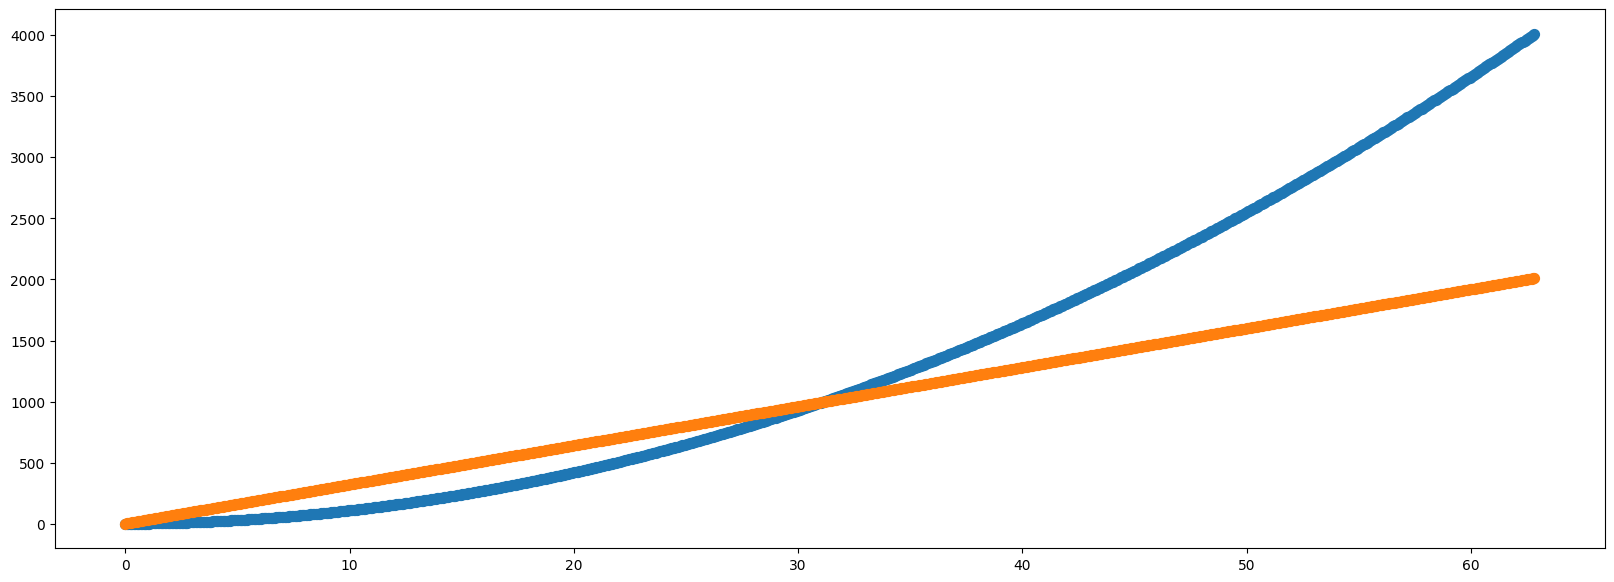

In [47]:
import matplotlib.pyplot as plt

y_pred = net.forward(X)

plt.figure(figsize=(20, 7))
plt.scatter(X.data[:, 1], Y.data, s=50)

plt.scatter(X.data[:, 1], y_pred.data, s=50)
plt.show()